# Introduction

Steps I followed
- Understand your data, check distributions
- Create a good Baseline
- Improve using Model
- Inspect Model
- Iterate

# Imports and Reading Data

In [4]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np_utils
%matplotlib inline
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D, DepthwiseConv2D, Conv2D, SeparableConv2D, MaxPooling1D, AveragePooling1D
from keras.layers import Input, concatenate, LeakyReLU
import gensim.downloader as api
from sklearn.model_selection import train_test_split
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import GlobalAveragePooling2D
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Nadam, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from keras.regularizers import l2
%config InlineBackend.figure_format='retina'
from keras_contrib.callbacks import CyclicLR
from keras.models import Model
from keras.layers import Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from data_science_utils.vision.keras import *
from time import time
import pandas as pd
import numpy as np

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import missingno as msno
import re
from joblib import Parallel, delayed
from data_science_utils import dataframe as df_utils
from data_science_utils import models as model_utils
from data_science_utils import plots as plot_utils
from data_science_utils.dataframe import column as column_utils
from data_science_utils import misc as misc
from data_science_utils import preprocessing as pp_utils
from data_science_utils import nlp as nlp_utils

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.datasets import imdb
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from data_science_utils.dataframe import get_specific_cols

import more_itertools
from more_itertools import flatten
import ast
from sklearn.preprocessing import LabelEncoder

import gc


import sys
import os
sys.path.append(os.getcwd())
from importlib import reload
import lib
reload(lib)
from lib import *

from oclr import OneCycleLR, LRFinder
from data_science_utils.models import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
import seaborn as sns


<module 'lib' from '/home/ec2-user/SageMaker/ML_hackathon_2019/lib.py'>

In [34]:
df_train = pd.read_csv("price_prediction/training.csv")
df_test = pd.read_csv("price_prediction/public_test_features.csv")

# Data Preprocessing

- Replace hyper-links, html, `\t`,`\n`,`\r`.  
- **Regex Preprocessing**
```python
preprocess_string = lambda x:re.sub('[^ a-zA-Z0-9%@_]',' ',nlp_utils.clean_text(x)) if x is not None and type(x)==str else x
```
- **Replace Numbers**
    - converts numbers to log2 and appends a _NUM
    - 4 will become \_NUM2\_, while anything from 1024-2048 will be \_NUM10\_
- **Word Frequency based Filtering**
    - Reduces vocab from 332242->87552
- **Word Lemmatization**
    - Reduced vocab size and faster training
- **Label Encoding Words/Chars**
    - Keras Embedding layer can take label encoded text and give train embeddings for us

In [35]:
df_train = preprocess_for_word_cnn(df_train,jobs=32)
le_train,le_transform, le = get_text_le("text")
_ = le_train(df_train)
df_train['text_encoded'] = le_transform(df_train)

df_test = preprocess_for_word_cnn(df_test,jobs=32)
df_test['text_encoded'] = le_transform(df_test)



Total Words before Min frequency filtering 332242
Total Words after Min frequency filtering 87552


In [68]:
gl_le_train,gl_le_transform, gl_le = get_le()
_ = gl_le_train(df_train)
df_train['GL_encoded'] = gl_le_transform(df_train)
df_test['GL_encoded'] = gl_le_transform(df_test)



In [69]:
df_train.head(3)

,TITLE,BULLET_POINTS,GL,text_encoded,PRICE,RPRICE,label,text,GL_encoded
0,"Livsmart Resin Jewellery Display Stand, 17x11c...",[Holds rings and other small items especially ...,gl_jewelry,"[28683, 1558, 273, 310, 196, 8, 4, 31, 453, 33...",507.62,23.0,__label__23.0,__label__23.0,31
1,Quantum Creation: Does the Supernatural Lurk i...,NaN,gl_digital_ebook_purchase,"[7567, 879, 12991, 1, 3900, 207, 267]",479.90,22.0,__label__22.0,__label__22.0,17
2,IZOD Men's Casual Shirt (8907163477392_ZKSH019...,"[Cotton linen,Cotton linen shirt,Checkered pat...",gl_apparel,"[5244, 24, 35, 32, 127, 26671, 64, 5368, 9, 90...",829.28,29.0,__label__29.0,__label__29.0,1


In [70]:
df_test[["ID","TITLE", "BULLET_POINTS","GL","GL_encoded","text_encoded"]].to_csv("price_prediction/test.csv",index=False)
df_train[["TITLE", "BULLET_POINTS","GL","GL_encoded","text_encoded","PRICE"]].to_csv("price_prediction/train.csv",index=False)


In [38]:
df_train = pd.read_csv("price_prediction/train.csv")
df_test = pd.read_csv("price_prediction/test.csv")


In [39]:
df_train['text_encoded'] = Parallel(n_jobs=16, backend="loky")(delayed(ast.literal_eval)(x) for x in tqdm(df_train['text_encoded']))
df_test['text_encoded'] = Parallel(n_jobs=16, backend="loky")(delayed(ast.literal_eval)(x) for x in tqdm(df_test['text_encoded']))


# Baselining

## GL Based baseline

In [5]:
df_train.GL.nunique()
df_test.GL.nunique()

set(df_test.GL.unique()) - set(df_train.GL.unique())


61

56

{'gl_bill_payments', 'gl_digital_products_3_accessory', 'gl_kindle_unlimited'}

In [ ]:
df_gl_means = df_train.groupby(["GL"])[['PRICE']].mean().reset_index()

df_results = df_test.merge(df_gl_means, on=["GL"],how="left")
df_results = df_results[["ID","PRICE"]]
df_results["PRICE"] = df_results["PRICE"].fillna(df_results["PRICE"].mean())

df_results.head()

df_results.to_csv("baseline.csv",index=False)


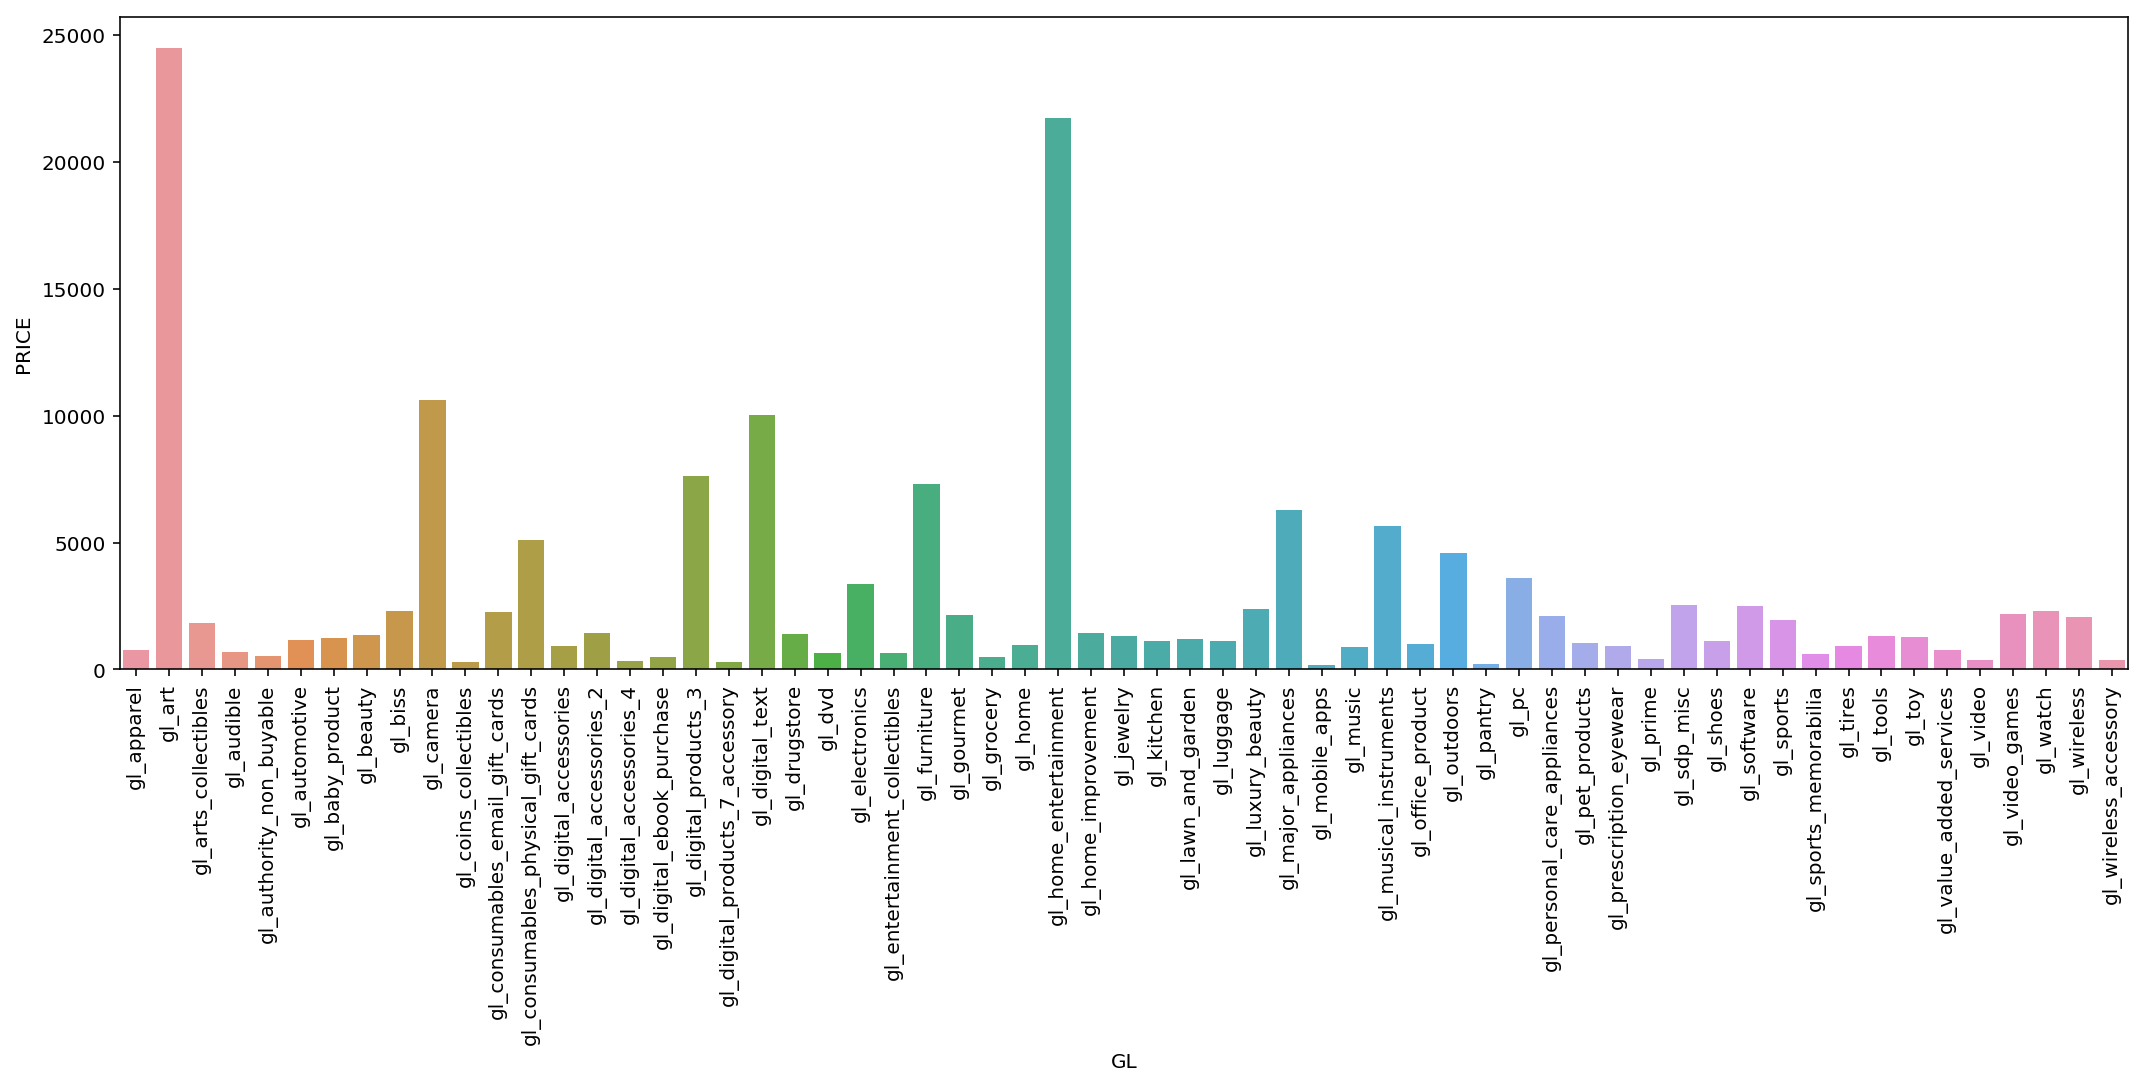

In [13]:
_ = plt.figure(figsize=(18,6));
_ = sns.barplot(x="GL",y="PRICE",data=df_gl_means)
_ = plt.xticks(rotation=90);
_ = plt.show();
# Plot GL level pricing

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


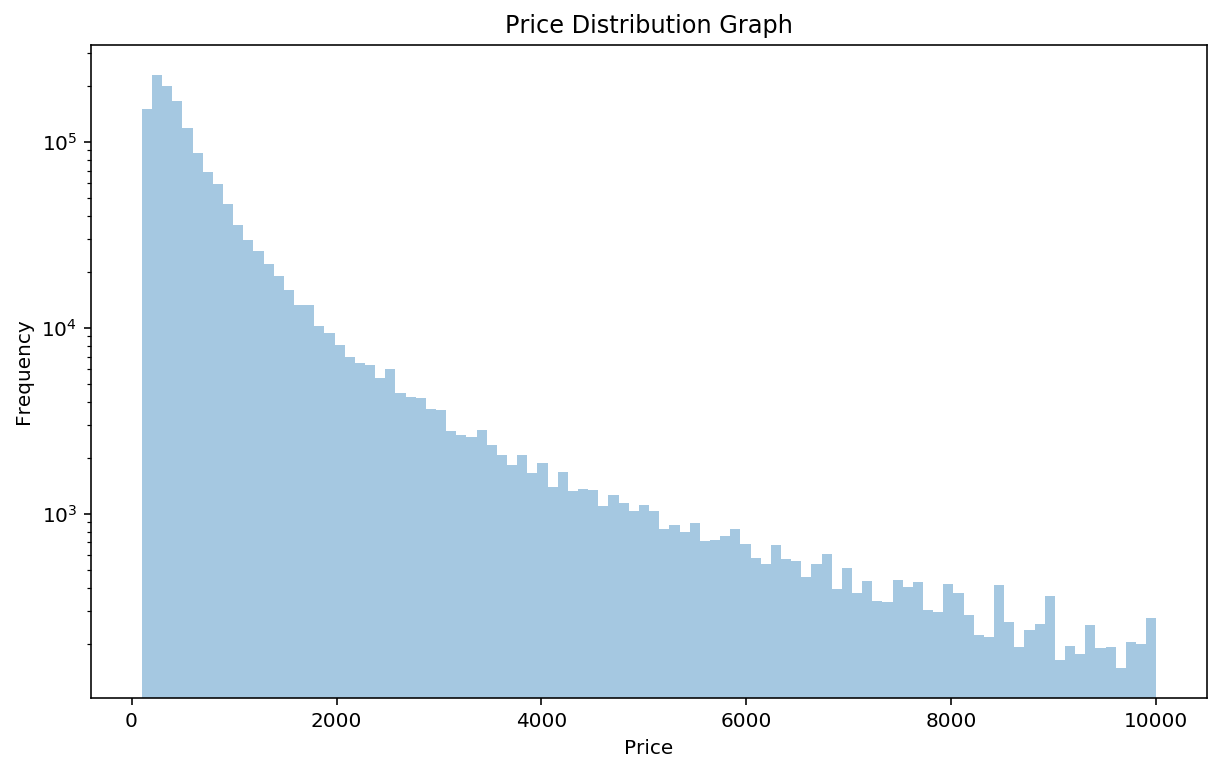

In [47]:
_ = plt.figure(figsize=(10,6));
_ = sns.distplot(df_train[df_train['PRICE']<1e4]['PRICE'].astype(float).values,bins=100,kde=False);
_ = plt.xlabel("Price");
_ = plt.ylabel("Frequency");
_ = plt.title("Price Distribution Graph");
_ = plt.semilogy();
_ = plt.show();

## Fasttext commandline based baseline

[Reference](https://fasttext.cc/docs/en/supervised-tutorial.html)

[Options](https://fasttext.cc/docs/en/options.html)

In [ ]:
!wget https://github.com/facebookresearch/fastText/archive/v0.2.0.zip > /dev/null
!unzip v0.2.0.zip > /dev/null
!cd fastText-0.2.0 && make -j16 > /dev/null

In [61]:
df_train_ft = preprocess_for_fasttext_cmd(df_train.copy(),jobs=32)
df_test_ft = preprocess_for_fasttext_cmd(df_test.copy(),jobs=32)

df_train_ft['RPRICE'] = np.ceil(np.cbrt(df_train['PRICE']))
df_train_ft['label'] = '__label__'
df_train_ft['label'] = df_train_ft['label'] + df_train_ft['RPRICE'].astype(str)

df_train_ft['text'] = df_train_ft['label']
df_train_ft['text'] = df_train_ft['text'] + " "
df_train_ft['text'] = df_train_ft['text'] + df_train_ft['char']

df_test_ft['text'] = df_test_ft['char']
train,test = train_test_split(df_train_ft[['text','PRICE']],test_size=0.2, random_state=42)
train[['text']].to_csv("fastText-0.2.0/train-1.txt",header=False,index=False)
test[['text']].to_csv("fastText-0.2.0/train-2.txt",header=False,index=False)

df_train_ft[['text']].to_csv("fastText-0.2.0/train.txt",header=False,index=False)
df_test_ft[['text']].to_csv("fastText-0.2.0/test.txt",header=False,index=False)

!head -n2 fastText-0.2.0/train.txt

__label__8.0 livsmart resin jewellery display stand  17x11cm  black[holds rings and other small items especially non hanging items each hand is specially designed to hang ring  bracelet or necklace beautiful gesture jewelry organizer ideal for retail shop counter display and personal use  helps you to organize rings]gl_jewelry
__label__8.0 quantum creation  does the supernatural lurk in the fourth dimension  gl_digital_ebook_purchase


In [57]:
df_train_ft[df_train_ft['RPRICE']>=80][["text","PRICE"]].sample(5)

,text,PRICE
843241,__label__83.0 apple iphone 7 plus rose gold ...,564419.640
1120071,__label__80.0 angel instrument fiber laser mar...,499000.000
1183035,__label__95.0 shree divyaratna 17 7 carat natu...,831600.000
358827,__label__84.0 pny quadro m6000 24 gb pci e gra...,582626.275
1395535,__label__84.0 ambience arts royal maharaja kin...,592372.880


In [63]:
!cd fastText-0.2.0 && ./fasttext supervised -input train-1.txt -output price_prediction -lr 0.2 -epoch 10
print("-"*80)
!cd fastText-0.2.0 && ./fasttext test price_prediction.bin train-2.txt
print("-"*80)
!cd fastText-0.2.0 && ./fasttext test price_prediction.bin train-2.txt 5
!cd fastText-0.2.0 && ./fasttext predict price_prediction.bin train-2.txt > validation.txt
!cd fastText-0.2.0 && ./fasttext predict price_prediction.bin test.txt > prediction.txt

Read 67M words
Number of words:  874961
Number of labels: 89
Progress: 100.0% words/sec/thread: 1298648 lr:  0.000000 loss:  1.676980 ETA:   0h 0m ETA:   0h 0mh 0m 1.725391 ETA:   0h 0m
--------------------------------------------------------------------------------
N	289921
P@1	0.392
R@1	0.392
--------------------------------------------------------------------------------
N	289921
P@5	0.175
R@5	0.877


In [64]:
df_verify = pd.read_csv("fastText-0.2.0/validation.txt",header=None)
df_verify.columns=["result"]
df_verify['values'] = df_verify['result'].apply(lambda x:x[9:]).astype(float)
df_verify['values'] = np.power(df_verify['values'],3)

mse = mean_squared_error(test['PRICE'],df_verify['values'].values)
mape = mean_absolute_percentage_error(test['PRICE'],df_verify['values'].values)
print("MSE = %.4f, MAPE = %.4f"%(mse,mape))

# MSE = 16667403.2996, MAPE = 55.1524
# MSE = 15540952.5923, MAPE = 58.4600



MSE = 15540952.5923, MAPE = 58.4600


In [ ]:
df_results = pd.read_csv("fastText-0.2.0/prediction.txt",header=None)

df_results.shape
df_results.columns=["result"]
df_results.head()

df_results['values'] = df_results['result'].apply(lambda x:x[9:]).astype(float)
df_results['values'] = np.power(df_results['values'],3)
df_results.head()

df_sub = df_test[['ID']]
df_sub['PRICE'] = df_results['values']
df_sub.to_csv("fasttext-cubic.csv",index=False)


# Modelling

- We use embedding dimension of 50 through-out

## Intro to 1D CNNs and Word Embeddings

**The Analogues**
- 1 image = 1 Asin Full Text
- Image Channels = Embedding Dimensions
- Images are 2D (depth is 3 channels), Text is 1D sequence (depth is 50 embedding dimensions)
- Edges/Gradients/Patterns in images = Text Phrases and important multi-word sequences

**Understanding the structure of each row**

Initially we have : Words -> Full text

Finally after embedding we get : Each word as a list of 50 numbers, Text as list of Words. 

Single row shape is `(1,50,#Words)`

Full Data shape is `(#Num examples, 50, #Word_Per_Row)`

## Winning Model: Using Words and Embedding Layer

In [137]:
# set parameters:
max_features = 50000
maxlen = 100
batch_size = 256
embedding_dims = 50
filters = 250
kernel_size = 3
hidden_dims = 250
epochs = 3

X,X_gl,y = df_train['text_encoded'].values,df_train['GL_encoded'].values,df_train['PRICE'].values
X_gl = X_gl.reshape((-1,1))
x_train, x_test,x_gl_train,x_gl_test, y_train, y_test = train_test_split(X,X_gl, y, test_size=0.2, random_state=42)

x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)


main_input = Input(shape=(maxlen,), dtype='int32', name='main_input')
embedding = Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen)(main_input)
x = Dropout(0.2)(embedding)

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:

vlayer = Conv1D(100,
                 5,
                 padding='same',
                 activation='relu',
                 strides=1)(embedding)
vlayer_out = GlobalMaxPooling1D()(vlayer)

x = Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1)(x)
# we use max pooling:
x = GlobalMaxPooling1D()(x)

x = concatenate([vlayer_out,x])
auxiliary_input =  Input(shape=(1,), dtype='int32', name='aux_input')
aux = Embedding(len(gl_le.classes_),
                    8,
                    input_length=1)(auxiliary_input)
aux = Flatten()(aux)
x = concatenate([x,aux])

# We add a vanilla hidden layer:
x = Dense(hidden_dims)(x)
x = Dropout(0.2)(x)
x = Activation('relu')(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
main_output = Dense(1)(x)

model = Model(inputs=[main_input, auxiliary_input], outputs=[main_output])
visualizer = Model(inputs=[main_input], outputs=vlayer)
embedder = Model(inputs=[main_input], outputs=embedding)

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mae'])

In [138]:

print("Param count = ", model.count_params())

model.fit([x_train,x_gl_train], y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=([x_test,x_gl_test], y_test))


Param count =  2653347
Train on 1159686 samples, validate on 289922 samples
Epoch 1/3
1159686/1159686 [==============================] - 114s 98us/step - loss: 4033495100.9434 - mean_absolute_error: 870.1332 - val_loss: 15897648.3024 - val_mean_absolute_error: 721.7361
Epoch 2/3
1159686/1159686 [==============================] - 112s 96us/step - loss: 4031518263.3513 - mean_absolute_error: 809.7256 - val_loss: 15422950.9724 - val_mean_absolute_error: 705.8510
Epoch 3/3
1159686/1159686 [==============================] - 112s 96us/step - loss: 4030210280.7716 - mean_absolute_error: 766.8738 - val_loss: 14820318.9456 - val_mean_absolute_error: 715.7829


In [139]:
K.set_value(model.optimizer.lr, K.get_value(model.optimizer.lr)/200)
model.fit([x_train,x_gl_train], y_train,
          batch_size=batch_size,
          epochs=2,
          validation_data=([x_test,x_gl_test], y_test))

Train on 1159686 samples, validate on 289922 samples
Epoch 1/2
1159686/1159686 [==============================] - 112s 96us/step - loss: 4028341958.3655 - mean_absolute_error: 767.2886 - val_loss: 14807689.1385 - val_mean_absolute_error: 706.1898
Epoch 2/2
1159686/1159686 [==============================] - 112s 96us/step - loss: 4028511993.7449 - mean_absolute_error: 760.7774 - val_loss: 14795674.4050 - val_mean_absolute_error: 697.0859


In [140]:
y_validation = model.predict([x_test,x_gl_test])
mse = mean_squared_error(y_test,y_validation.reshape((-1)))
mape = mean_absolute_percentage_error(y_test,y_validation.reshape((-1)))
print("MSE = %.4f, MAPE = %.4f"%(mse,mape))

# MSE = 15640877.1138, MAPE = 81.4073
# MSE = 15617069.5426, MAPE = 82.5959
# MSE = 15270309.0615, MAPE = 78.2024

MSE = 14795674.3211, MAPE = 91.0456


In [141]:
from keras.models import load_model
model.save('model.h5')
model = load_model('model.h5')

visualizer.save('visualizer.h5')
visualizer = load_model('visualizer.h5')

embedder.save('embedder.h5')
embedder = load_model('embedder.h5')

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


## Other Models

- Model 2: Using Characters and Embedding Layer
    - Very Less Preprocessing needed since used set of characters is around 128.
    - Since the Sequence length is very long this is harder to tune though.
- Model 3: Using Pretrained Glove-twitter-50 Embeddings
- Model 4: The Fallen Ensemble

# Inspecting the Model

## Inspecting Embeddings

- Word Cloud and hue on price bucket (Select top 10 words from each bucket)
- 

## Model Params and Summary

## Model Image representation

<module 'keras.utils.vis_utils' from '/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/utils/vis_utils.py'>

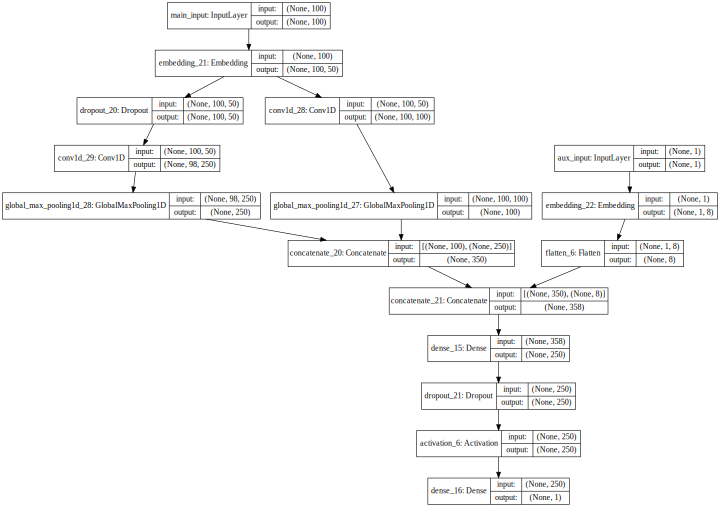

In [142]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
reload(keras.utils.vis_utils)
m2d = model_to_dot(model, show_shapes=True,)
m2d.set_size('10x24')
SVG(m2d.create(prog='dot', format='svg'))

In [2]:
# Ensemble's image

## How Do Costly vs Cheaper Asins Look in Images

- We use a 3 channel intermediate layer and use it here
- We check 5 images from each price bucket

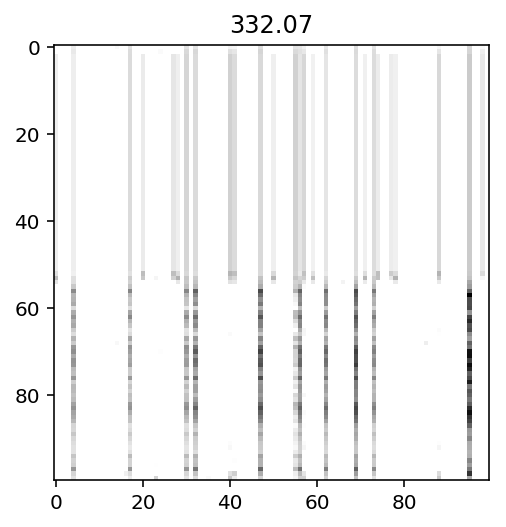

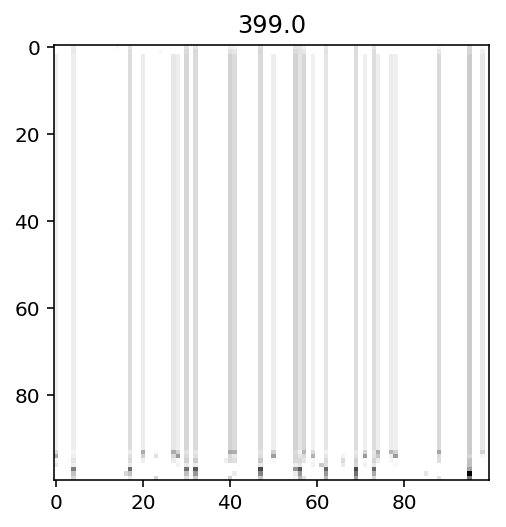

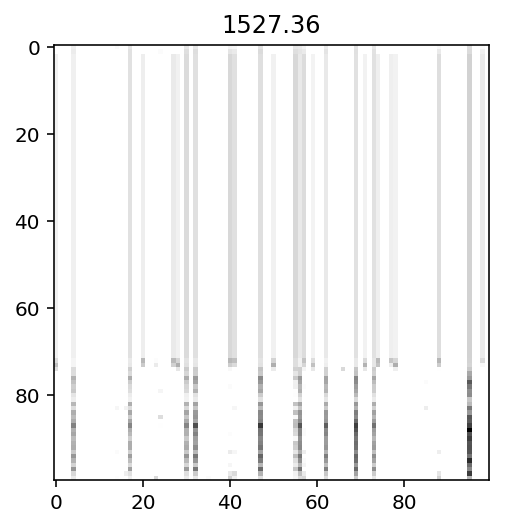

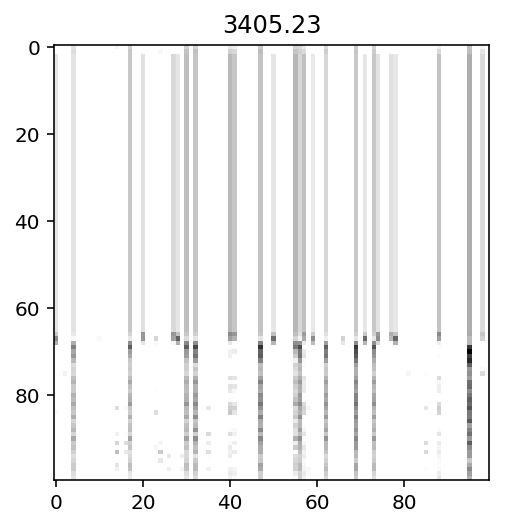

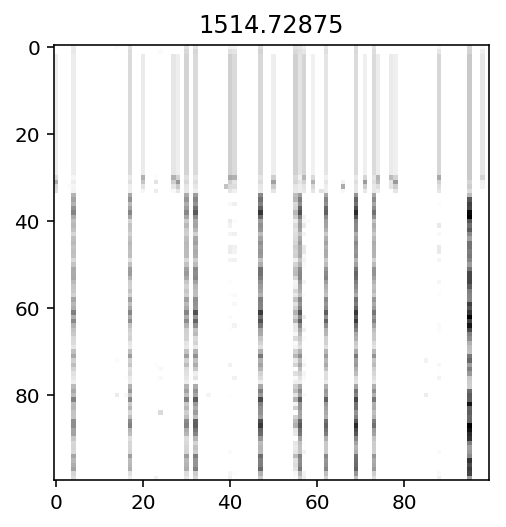

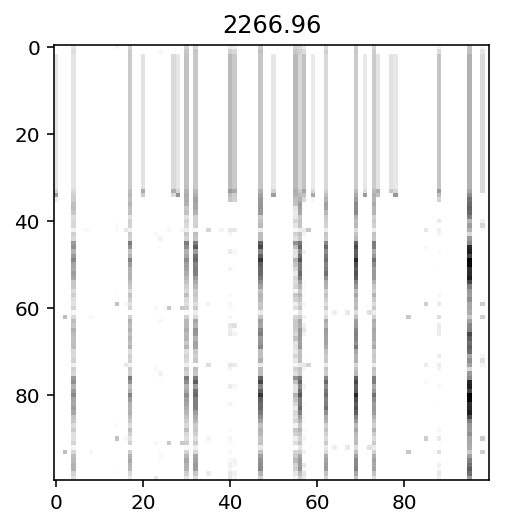

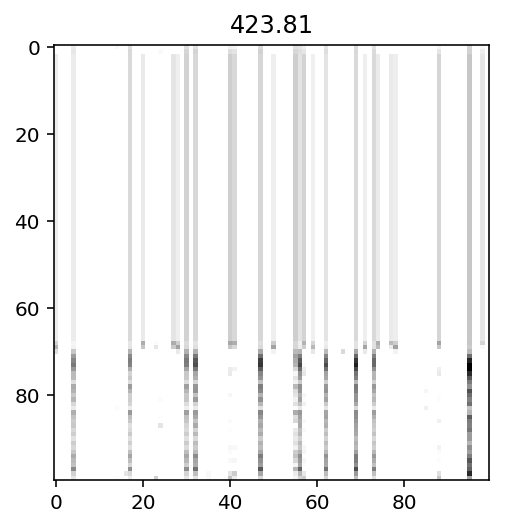

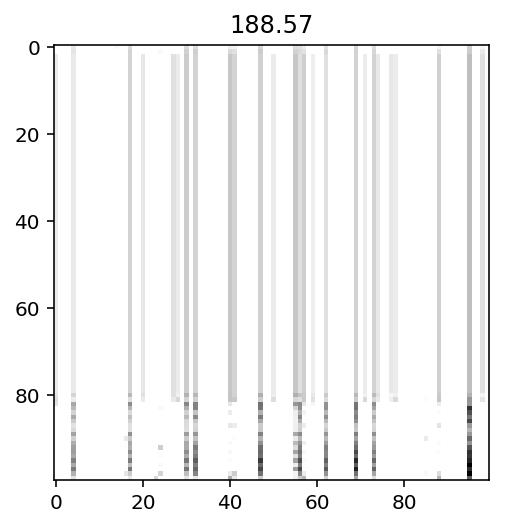

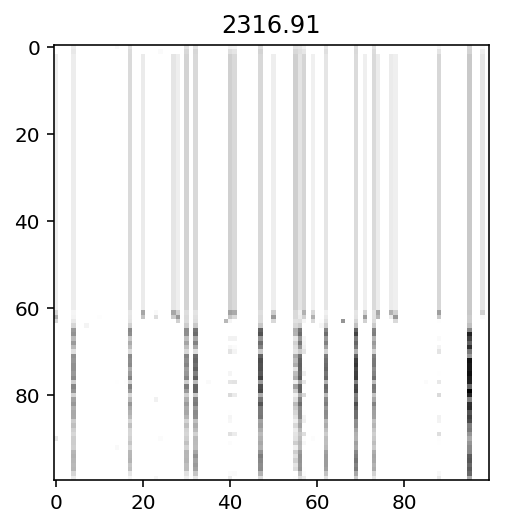

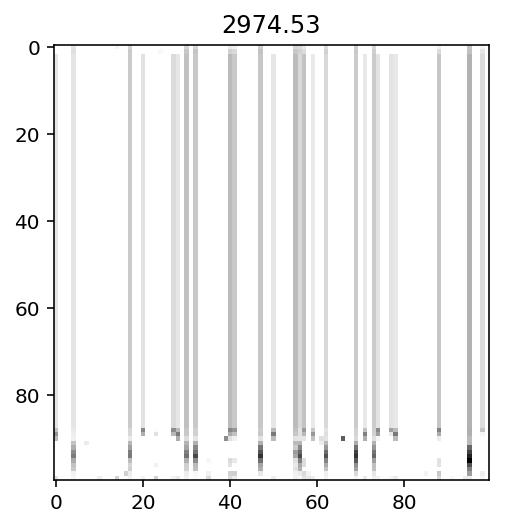

In [146]:
for i in range(10):
    idx = np.random.randint(0,len(x_test))
    vl = visualizer.predict([x_test[idx:idx+1]])
    _ = plt.figure();
    _ = plt.title(y_test[idx:idx+1][0]);
    _ = plt.imshow(vl[0],cmap="gray_r");
    _ = plt.show();

## Error Inspection

- We inspect top 10 Asins by RMSE, MAE, MAPE to see if we can change our preprocessing style

# Observations and Suggestion for Improvements

## Observations

- Finding Good Learning rate was important
- Model Trained Embeddings did better than Pretrained Embeddings (Data size may be a reason)
- Going Wide Helped
- P3.8x Large Sagemaker Instance has multi-gpu (8 total), this needs separate Tensorflow sessions, I used separate notebooks
- Normalizing word vectors for Pretrained model was lowering performance, word vector lengths matter when you consider Text classification tasks, for NLP tasks like similarity they don't since cosine distance is used.
- The Process of using Word CNNs is easily carried over to Sub-categories Classification
- Why Ensembling Did not work?
    - Models with dropouts are like ensembles themselves
    - Only significant architecture or preprocessing step difference will help
- Why Char CNN did not work?
    - Long training time and huge number of computations
- Following a structured process was important
    - You might think something will improve the results but trying things without reasoning usually gives sub-par results

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


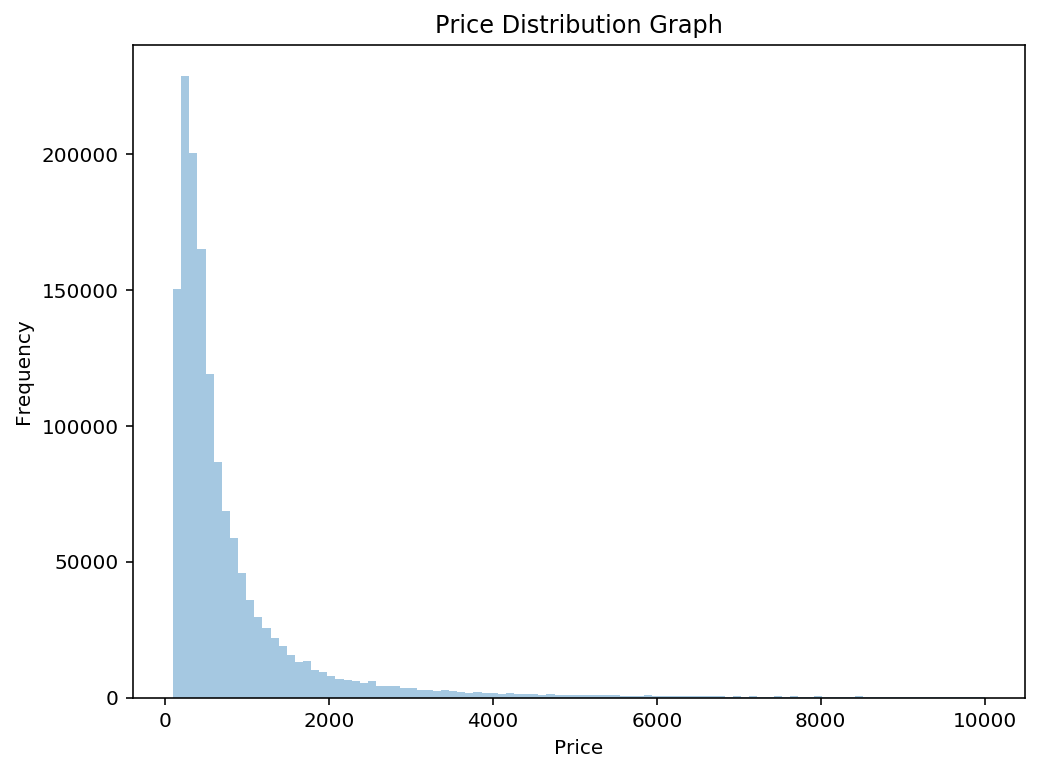

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


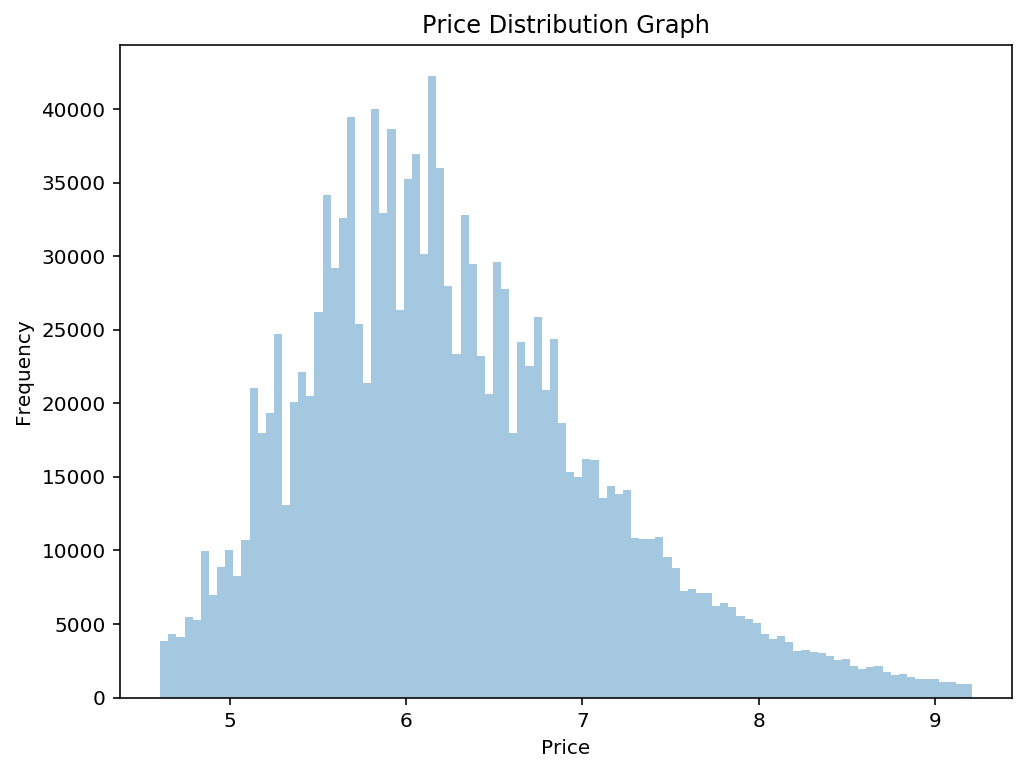

In [45]:
# Target Distribution Histogram

# Target Distribution Histogram
_ = plt.figure(figsize=(8,6));
_ = sns.distplot(df_train[df_train['PRICE']<1e4]['PRICE'].astype(float).values,bins=100,kde=False);
_ = plt.xlabel("Price");
_ = plt.ylabel("Frequency");
_ = plt.title("Price Distribution Graph");
# _ = plt.semilogy();
_ = plt.show();

_ = plt.figure(figsize=(8,6));
_ = sns.distplot(np.log(df_train[df_train['PRICE']<1e4]['PRICE'].astype(float).values),bins=100,kde=False);
_ = plt.xlabel("Price");
_ = plt.ylabel("Frequency");
_ = plt.title("Price Distribution Graph");
# _ = plt.semilogy();
_ = plt.show();

## Improvements

- **Improving Word Embeddings**
    - Pretrained Fasttext or Bert/Elmo Models for text representation
    - Higher Embedding Dimensions for Text
    - Initializing Embedding layer with Pretrained vectors
        - Helpful for representing low frequency words.
        - This will help us by not filtering low vocab words before training.
    - Trying POS tags with lemmatized words
- **Target Variable**
    - Training with Log/CubeRoot/Standard Scaling of target since target is skewed.
    - Bucketing/Quantizing: Dividing prices into cube-rooted buckets and then feeding the top 10 bucket prediction to final model.
- **Training Improvements**
    - LR scheduling, Cyclic LR and Super Convergence
    - More Epochs
- **Other Suggestions**
    - Inspecting Errors and finding text patterns we missed
    - GL specific Models (avoid global mean bias)

## References

# Asin Classification into Sub-Categories